In [1]:
# Importing libraries and modules

import os
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#Lets Authenticate and Initialize Earth Engine
#ee.Authenticate()

In [7]:
ee.Initialize()

In [8]:
#Loading shapefile(aoi)using Geopandas

GH_shp = gpd.read_file('C:/Users/user/Documents/GEEMAP Projects/Data/GHANA BD/GHANA_BD.shp')

In [9]:
#Creating a geojson representation for a geopandas Dataframe 
GH_geojson = geemap.gdf_to_ee(GH_shp)

In [10]:
#Using GEEMAP basemaps
Map= geemap.Map()

In [11]:
#ESRI Global Sentinel-2 10m land use/land cover time series

# Filter the Land Cover data Collection by date, AOI and cover
start_date = '2023-01-01'
end_date = '2023-12-31'

lulc_data= ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS").filterDate(start_date,end_date).filterBounds(GH_geojson);


# Check if there are any images available
count = lulc_data.size().getInfo()
if count == 0:
    print("No images available for the specified criteria.")


In [12]:
# Clip the Land cover data to the shapefile 
lulc_clip = lulc_data.map(lambda image: image.clip(GH_geojson))

In [13]:
# Define a dictionary which will be used to make legend and visualize image on map
legend_dict = {
    1: "Water",
    2: "Trees",
    4: "Flooded Vegetation",
    5: "Crops",
    7: "Built Area",
    11: "Rangeland"  
}

legend_colors = {
    "Water": "#1A5BAB",
    "Trees": "#358221",
    "Flooded Vegetation": "#87D19E",
    "Crops": "#FFDB5C",
    "Built Area": "#ED022A",
    "Rangeland": "#C6AD8D"  
}

# Remapping values
remap_values = {
    1: 1,
    2: 2,
    4: 3,
    5: 4,
    7: 5,
    11: 6
}


In [14]:
# Create a mosaic image from the ImageCollection and remap the values
lulc_clip_mosaic = lulc_clip.mosaic().select('b1').remap(list(remap_values.keys()), list(remap_values.values()))

In [15]:
# Add image to the map
lulc_viz = {
    'min': 1,
    'max': 6,
    'palette': [legend_colors[legend_dict[i]] for i in sorted(legend_dict.keys())]
}
Map.addLayer(lulc_clip_mosaic, lulc_viz, '2023 ESRI LULC 10m')

In [16]:
# Add a legend to the map using geemap's built-in function
Map.add_legend(legend_title='ESRI 2023 Land Cover', legend_dict=legend_colors)

In [17]:
# Center the map on the shapefile
Map.centerObject(GH_geojson, 7)  

In [18]:
# Display the map
Map.addLayerControl()  # This will add a layer control panel to the map.
Map

Map(center=[7.96388656439195, -1.2082882642458035], controls=(WidgetControl(options=['position', 'transparent_…

*NB: This map uses an updated model 2023 from the 10-class model and combines Grass(formerly class 3) and Scrub (formerly class 6) into a single Rangeland class (class 11). 
The original Esri 2020 Land Cover collection uses 10 classes (Grass and Scrub separate) and an older version of the underlying deep learning model*.

In [22]:
# Function to calculate the percentage of each land cover class
def calculate_land_cover_statistics(image, scale, region):
    # Calculate the area of each land cover class
    class_areas = image.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=GH_geojson,
        scale=scale,
        maxPixels=1e10
    ).getInfo()
    
    if class_areas is None or not class_areas:
        print("No data returned from reduceRegion operation.")
        return {}
    
    # Extract the classification histogram
    classification_histogram = class_areas.get('b1')
    
    if classification_histogram is None:
        print("Unable to retrieve the classification histogram from the image.")
        print("class_areas:", class_areas)
        return {}
        
    # Print the classification histogram to debug
    print("Classification Histogram:", classification_histogram)
    
    # Calculate the total area
    total_area = sum(classification_histogram.values())
    
    # Calculate the percentage and area (in square kilometers) of each class
    class_percentages = {}
    class_areas_km2 = {}
    for key, value in classification_histogram.items():
        class_name = legend_dict.get(int(key), "Unknown Class")
        percentage = (value / total_area) * 100
        area_km2 = (value * scale * scale) / 1e6  # Convert area from m^2 to km^2
        class_percentages[class_name] = percentage
        class_areas_km2[class_name] = area_km2
    
    return class_percentages, class_areas_km2

In [23]:
# Calculate the percentage and area (in square kilometers) of each class

lulc_clip_mosaic = lulc_clip.mosaic()
scale = 30  # Adjust the scale as needed
region = GH_geojson
land_cover_percentages, land_cover_areas_km2 = calculate_land_cover_statistics(lulc_clip_mosaic , scale, region)

# Print the percentages and areas
if land_cover_percentages and land_cover_areas_km2:
    for lc_class in legend_dict.values():
        percentage = land_cover_percentages.get(lc_class, 0)
        area_km2 = land_cover_areas_km2.get(lc_class, 0)
        print(f"{lc_class}: {percentage:.2f}% - {area_km2:.2f} km²")

Classification Histogram: {'1': 10129111.2627451, '10': 32777.141176470584, '11': 120509808.12156862, '2': 119986067.31764702, '3': 4, '4': 949502.0705882353, '5': 8101324.882352941, '6': 38, '7': 10718748.83921569, '8': 102475.59999999999, '9': 17.75294117647059}
Water: 3.74% - 9116.20 km²
Trees: 44.35% - 107987.46 km²
Flooded Vegetation: 0.35% - 854.55 km²
Crops: 2.99% - 7291.19 km²
Built Area: 3.96% - 9646.87 km²
Rangeland: 44.55% - 108458.83 km²


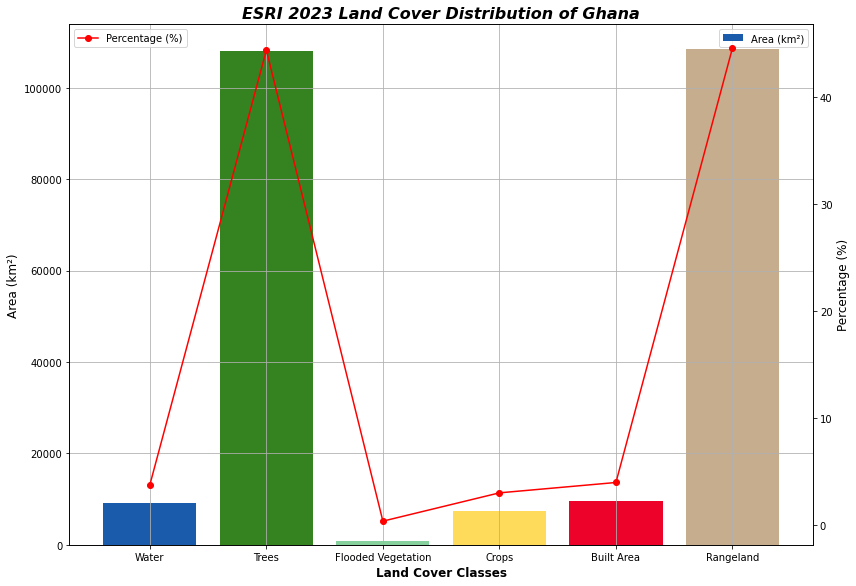

In [24]:
# Visualize the classification statistics as a dual-axis bar chart
if land_cover_percentages and land_cover_areas_km2:
    # Extract class names, percentages, and areas for plotting
    class_names = [c for c in legend_dict.values() if c in land_cover_percentages and c in legend_colors]
    percentages = [land_cover_percentages[c] for c in class_names]
    areas_km2 = [land_cover_areas_km2[c] for c in class_names]
    colors = [legend_colors[c] for c in class_names]
    
    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Plot bars on primary y-axis (area in km²)
    bars = ax1.bar(class_names, areas_km2, color=colors, alpha=1.0, label='Area (km²)')
    ax1.set_ylabel('Area (km²)', fontsize=12)
    ax1.set_xlabel('Land Cover Classes', fontsize=12, fontweight='bold')
    
    # Create a secondary y-axis for percentages
    ax2 = ax1.twinx()
    ax2.plot(class_names, percentages, color='r', marker='o', linestyle='-', label='Percentage (%)')
    ax2.set_ylabel('Percentage (%)', fontsize=12)
    
    # Add legends and grid
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax1.grid(True)
    ax2.grid(False)
    
    # Adjust layout and display the plot
    fig.tight_layout()
    plt.title('ESRI 2023 Land Cover Distribution of Ghana', fontsize=16, fontweight='bold', fontstyle='italic')
    plt.show()

| Land Cover Class       | Percentage (%) | Area (km²)   |
|------------------------|----------------|--------------|
| Water                  | 3.74           | 9116.20      |
| Trees                  | 44.35          | 107987.46    |
| Flooded Vegetation     | 0.35           | 854.55       |
| Crops                  | 2.99           | 7291.19      |
| Built Area             | 3.96           | 9646.87      |
| Rangeland              | 44.55          | 108458.83    |

In [29]:
import markdown2
import imgkit

# Define the markdown content
markdown_content = """
| Land Cover Class       | Percentage (%) | Area (km²)   |
|------------------------|----------------|--------------|
| Water                  | 3.74           | 9116.20      |
| Trees                  | 44.35          | 107987.46    |
| Flooded Vegetation     | 0.35           | 854.55       |
| Crops                  | 2.99           | 7291.19      |
| Built Area             | 3.96           | 9646.87      |
| Rangeland              | 44.55          | 108458.83    |
"""

# Convert the markdown content to HTML
html_content = markdown2.markdown(markdown_content)

# Specify the path where you want to save the PNG
out_img = 'C:/Users/user/Documents/GEEMAP Projects/Land cover 2023/GH_2023LandCoverTable.png'

# Specify options for imgkit
options = {
    'format': 'png',
    'encoding': "UTF-8",
    'quiet': '',
    'width': '800'  # Increase width for larger image
}

# Convert HTML content to PNG image
imgkit.from_string(html_content, out_img, options=options)

OSError: 
No wkhtmltoimage executable found: "command not found"
If this file exists please check that this process can read it.
Otherwise please install wkhtmltopdf - http://wkhtmltopdf.org

        